/content/Screenshot 2025-04-08 111807.png


Saving Screenshot 2025-04-08 111807.png to Screenshot 2025-04-08 111807 (5).png


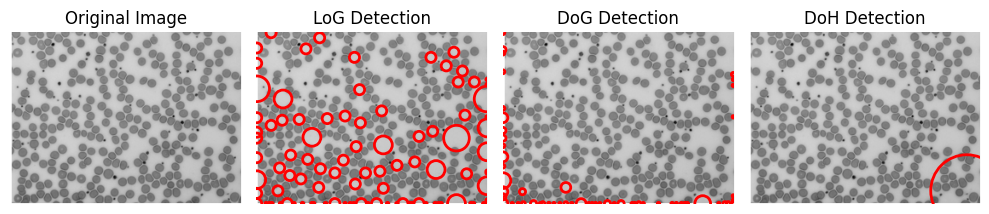

Number of blobs detected with LoG: 96
Number of blobs detected with DoG: 57
Number of blobs detected with DoH: 1


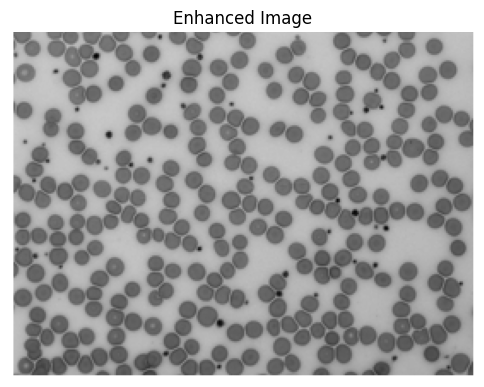

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, color, io
from skimage.filters import gaussian
from skimage.feature import blob_log, blob_dog, blob_doh
from google.colab import files

print("/content/Screenshot 2025-04-08 111807.png")
uploaded = files.upload()

# Load the image (assuming the first uploaded file)
filename = next(iter(uploaded))
image = io.imread(filename)


if image.shape[-1] == 4:
    image = image[..., :3]
image_gray = color.rgb2gray(image)


# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(141)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# 1. Blob Detection using Laplacian of Gaussian (LoG)
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=0.1)

# Compute radii in the 3rd column
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

# 2. Blob Detection using Difference of Gaussian (DoG)
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

# 3. Blob Detection using Determinant of Hessian (DoH)
blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=0.01)
blobs_doh[:, 2] = blobs_doh[:, 2] * np.sqrt(2)

# Function to plot blobs
def plot_blobs(image, blobs, title, position):
    plt.subplot(position)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        plt.gca().add_patch(c)

# Plot results
plot_blobs(image_gray, blobs_log, 'LoG Detection', 142)
plot_blobs(image_gray, blobs_dog, 'DoG Detection', 143)
plot_blobs(image_gray, blobs_doh, 'DoH Detection', 144)

plt.tight_layout()
plt.show()

# Print the number of detected blobs
print(f"Number of blobs detected with LoG: {len(blobs_log)}")
print(f"Number of blobs detected with DoG: {len(blobs_dog)}")
print(f"Number of blobs detected with DoH: {len(blobs_doh)}")

# Optional: Enhance image quality (simple contrast adjustment)
from skimage import exposure

# Enhance contrast
image_enhanced = exposure.adjust_gamma(image_gray, gamma=1.5)

# Display enhanced image
plt.figure(figsize=(6, 6))
plt.imshow(image_enhanced, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')`
plt.show()

In [ ]:
!pip install "deeplake<4"

In [ ]:


!pip install "deeplake<4" #install DeepLake version 3

# Step 2: Import required libraries
import deeplake
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import time
import matplotlib.pyplot as plt

# Step 3: Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize for AlexNet and VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Step 4: Create a custom dataset class for Deep Lake v4
class CIFAR100DeepLakeDataset(Dataset):
    def __init__(self, path, transform=None):
        # Use deeplake.load for Deep Lake v3
        self.ds = deeplake.load(path, read_only=True)
        self.transform = transform

    def __len__(self):
        return self.ds.tensors['images'].shape[0]

    def __getitem__(self, idx):
        image = self.ds.tensors['images'][idx].numpy()
        label = self.ds.tensors['labels'][idx].numpy().item()

        if self.transform:
            image = self.transform(image)

        return image, label



# Step 5: Load datasets using the new class
train_dataset = CIFAR100DeepLakeDataset("hub://activeloop/cifar100-train", transform)
test_dataset = CIFAR100DeepLakeDataset("hub://activeloop/cifar100-test", transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

alexnet.classifier[6] = nn.Linear(4096, 100)
vgg16.classifier[6] = nn.Linear(4096, 100)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Accuracy: {100 * correct / total:.2f}%")

    return model


def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    inference_time = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            start_time = time.time()
            outputs = model(images)
            inference_time += time.time() - start_time
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}% | Inference Time: {inference_time:.2f}s")
    return accuracy, inference_time


print("🔧 Training AlexNet...")
alexnet_trained = train_model(alexnet, train_loader, epochs=5)
alex_acc, alex_time = evaluate_model(alexnet_trained, test_loader)


print("\n🔧 Training VGG16...")
vgg16_trained = train_model(vgg16, train_loader, epochs=5)
vgg_acc, vgg_time = evaluate_model(vgg16_trained, test_loader)

# Step 11: Final Comparison
print("\n📊 Final Comparison:")
print(f"AlexNet Accuracy: {alex_acc:.2f}% | Inference Time: {alex_time:.2f}s")
print(f"VGG16 Accuracy: {vgg_acc:.2f}% | Inference Time: {vgg_time:.2f}s")


/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.19) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/cifar100-train



|

hub://activeloop/cifar100-train loaded successfully.



-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/cifar100-test



-

hub://activeloop/cifar100-test loaded successfully.



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 124MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed

🔧 Training AlexNet...
